# Phase transformations and reduction (Blakely, 1996)

### This notebook shows how to compute the reduction transformation, which is computed in Fourier domain using wave numbers calculation in $X$ and $Y$ directions through the expression:

# $$\mathcal{F}(\Delta T_i) = \mathcal{F}(\Delta T) \, \mathcal{F}(\psi)$$

### where $\mathcal{F}(\Delta T)$ is the Fourier transform of the magnetic data and $\mathcal{F}(\psi)$ is the filtering operator.

### The operator $\mathcal{F}(\psi)$ is calculated as a function of the "old" ($\Theta_s$ and $\Theta_f$) and "new" ($\Theta_s^{'}$ and $\Theta_f^{'}$) directions for the magnetization of the source and the geomagnetic field. It can be expressed by:

# $$ \mathcal{F}(\psi) = \dfrac{\Theta_s^{'}\, \Theta_f^{'}}{\Theta_s\, \Theta_f}$$
#### **It is important to remember that our function was implemented to receive any new directions for the geomagnetic field (inclination and declination defines as $I$ and $D$) and also for the magnetization of the source ($I_0$ and $D_0$). The both values are input for the function and must be written as an array or a simple list, such as $[I0, \, D_0]$ for example.**

#### In this notebook, it will be showing two simple examples: (i) a solid sphere and (ii) a rectangular prism

In [162]:
# Importing all usefull libraries
import numpy as np
import gravmag as gmc
import datafiltering as df
from auxiliars import addnoise
import matplotlib.pyplot as plt

In [177]:
# Definition for number of points and grid creation
n = 200
x = np.linspace(-2000., 2000., n)
y = np.copy(x)
z = np.random.normal(loc = -50., scale = 1., size = n)
# Creat the grid file
X, Y = np.meshgrid(x, y)

In [255]:
#Informations about the model - sphere
sphere = [0., 0., 600., 100., 2.]
# Inclination and declination (source and field)
[incs, decs] = [55., -48.]
field = [55., -48.]
pole = [90., 0]

In [261]:
# Calculating the total field anomaly
tf = gmc.sphere_tfa(X, Y, z, sphere, (incs, decs), field)
tfa_pole = gmc.sphere_tfa(X, Y, z, sphere, pole, pole)

In [262]:
# Adding noise to the data
tfa = addnoise(tf, 0.01) # 1 percent

In [263]:
# Definition for the new directions
fnew = [90., 0.]
snew = [90., 0.]

In [264]:
# Calculate the reduce to pole
rtp = df.reduction(X, Y, tfa, field, (incs, decs), fnew, snew)

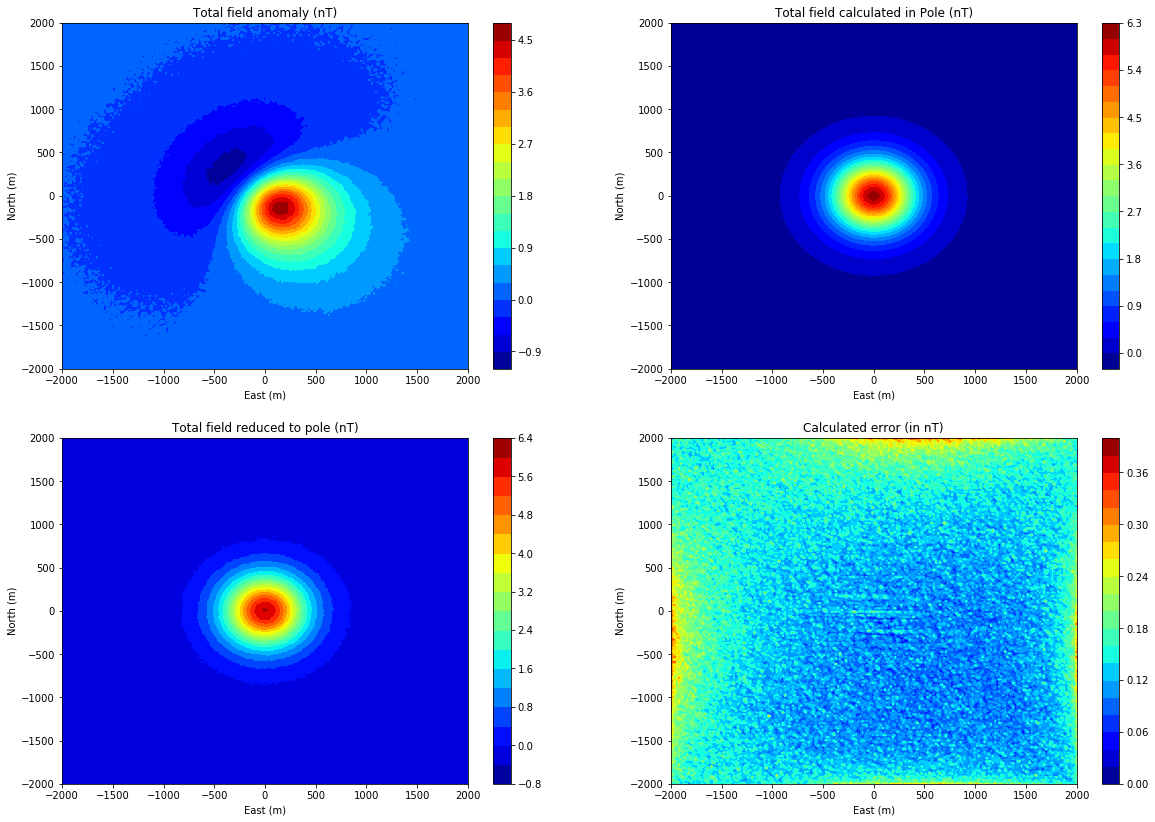

In [265]:
# Plotting all results
plt.close('all')
plt.figure(figsize=(20,14))

plt.subplot(2, 2, 1)
plt.title('Total field anomaly (nT)')
plt.contourf(Y, X, tfa, 20, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Total field calculated in Pole (nT)')
plt.contourf(Y, X, tfa_pole, 20, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('Total field reduced to pole (nT)')
plt.contourf(Y, X, rtp, 20, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('Calculated error (in nT)')
plt.contourf(Y, X, (tfa_pole - rtp), 20, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.show()

In [280]:
#Informations about the model - prism
prism = [-500., 500., -500., 500., 1000., 1500., 1.]
# Inclination and declination (source and field)
source = [66., -18.]
field = [49., 15.]

In [281]:
# Calculating the total field anomaly
tfp = gmc.prism_tf(X, Y, z, prism, source, field)
tfp_pole = gmc.prism_tf(X, Y, z, prism, (90., 0.), (90., 0.))

In [282]:
# Adding Gaussian noise 
tfap = addnoise(tfp, 0.05) # 5 percent

In [283]:
# Calculate the reduction to pole
res = df.reduction(X, Y, tfap, field, source, (90., 0.), (90., 0.))

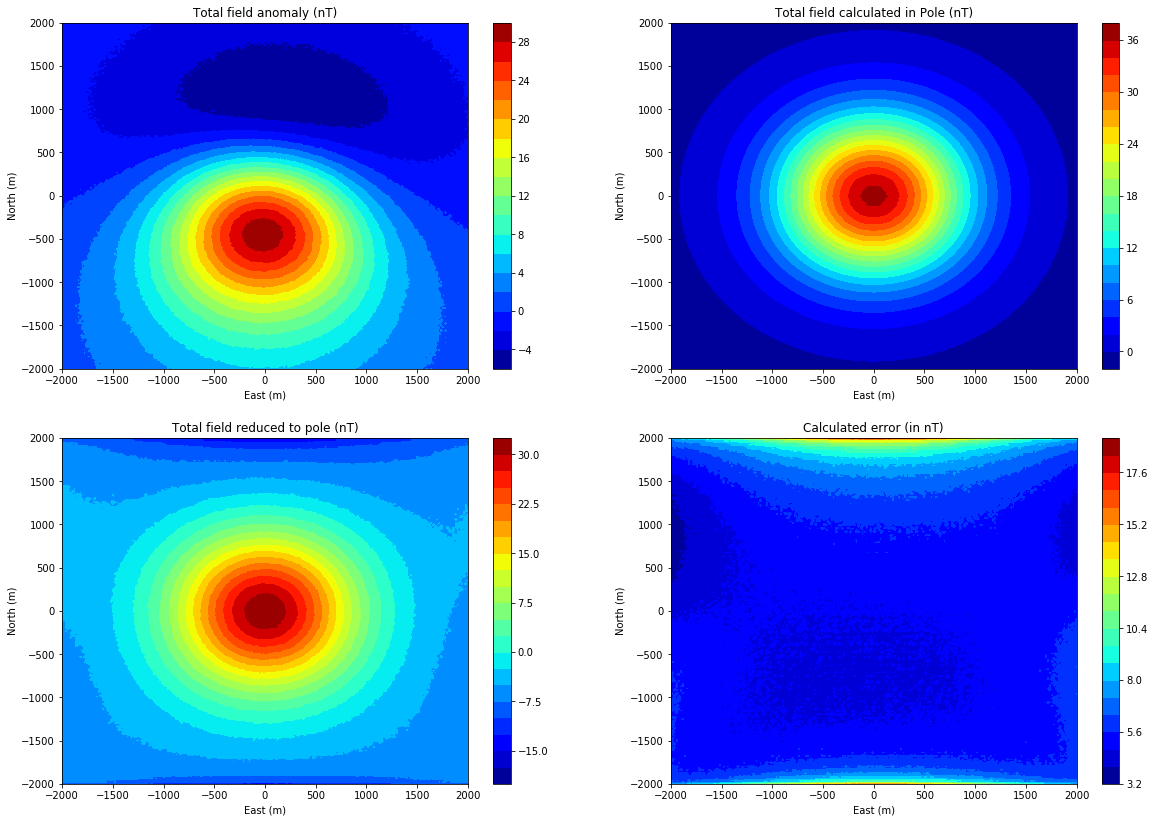

In [285]:
# Plotting all results
plt.close('all')
plt.figure(figsize=(20,14))

plt.subplot(2, 2, 1)
plt.title('Total field anomaly (nT)')
plt.contourf(Y, X, tfap, 20, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title('Total field calculated in Pole (nT)')
plt.contourf(Y, X, tfp_pole, 20, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title('Total field reduced to pole (nT)')
plt.contourf(Y, X, res, 20, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title('Calculated error (in nT)')
plt.contourf(Y, X, (tfp_pole - res), 20, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.colorbar()

plt.show()